# Stack Overflow: Tag Prediction

### Data Source

https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data

### Problem Statemtent 

Suggest the tags based on the content that was there in the question posted on Stackoverflow.

### Real World / Business Objectives and Constraints

1. No strict latency constraints - can take couple of minutes to suggest the tags.
2. The customer experience can be impacted if incorrect tags are detected.
3. High precision and high recall is required

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import os
import numpy as np

In [ ]:
#!pip install wordcloud
#!pip install sqlalchemy
#!pip install skmultilearn
#!pip install scikit-multilearn
#python -c "import skmultilearn"

# Exploratory Data Analysis

### Loading the data

In [3]:
data = pd.read_csv("train.csv")
print("The number of rows in the data",data.shape[0])
print("The number of attributes in the data",data.shape[1])

The number of rows in the data 6034195
The number of attributes in the data 4


In [4]:
# Displaying the head of data
data.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


### Checking for duplicates

In [5]:
data_duplicate = data[data.duplicated(['Title','Body','Tags'])]
print("The number of duplicate rows in the data",data_duplicate.shape[0])

The number of duplicate rows in the data 1827881


In [6]:
# Counting the number of duplicates for ech question
count_duplicate_data = data.pivot_table(index=['Title','Body','Tags'], aggfunc='size')
count_duplicate_data = pd.DataFrame(count_duplicate_data)
count_duplicate_data = count_duplicate_data.rename(columns = {0:'Count'})
count_duplicate_data.head()

Count
Title                                              Body                                               Tags                                      
     Implementing Boundary Value Analysis of So... <pre><code>#include&lt;iostream&gt;\n#include&l... c++ c                                    1
    Dynamic Datagrid Binding in Silverlight?       <p>I should do binding for datagrid dynamically... c# silverlight data-binding              1
                                                                                                      c# silverlight data-binding columns      1
    java.lang.NoClassDefFoundError: javax/servl... <p>I followed the guide in <a href="http://stac... jsp jstl                                 1
    java.sql.SQLException:[Microsoft][ODBC Driv... <p>I use the following code</p>\n\n<pre><code>t... java jdbc                                2

In [7]:
# number of times each question appeared in our database
num_of_times = count_duplicate_data['Count'].value_counts()
num_of_times = pd.DataFrame(num_of_times)
num_of_times = num_of_times.rename(columns = {'Count' : 'Number of questions'})
num_of_times['Number of times appeared'] = num_of_times.index
num_of_times = num_of_times.set_index(np.arange(6))
num_of_times

,Number of questions,Number of times appeared
0,2656277,1
1,1272335,2
2,277575,3
3,90,4
4,25,5
5,5,6


In [8]:
filtered_data = data.drop_duplicates(subset=['Title', 'Body', 'Tags'])
print("The number of rows in the data after removing duplicate rows",filtered_data.shape[0])

The number of rows in the data after removing duplicate rows 4206314


In [9]:
print("The percentage of duplicate data removed-----",((data.shape[0] - filtered_data.shape[0]) / data.shape[0])*100)

The percentage of duplicate data removed 30.29204392632323


### Analysis of tags

### Total number of unique tags

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
vector_tags = vectorizer.fit_transform(filtered_data['Tags'].astype('U').values)
print("Number of data points :", vector_tags.shape[0])
print("Number of unique tags :", vector_tags.shape[1])

Number of data points : 4206314
Number of unique tags : 42048


In [30]:
# Printing some tags
tags = vectorizer.get_feature_names()
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


### Number of times a tag appeared

In [85]:
freqs = vector_tags.sum(axis=0).A1
result = dict(zip(tags, freqs))
tags_col = []
counts = []
for key, value in result.items():
            tags_col.append(key)
            counts.append(value)
            
tags_df = list(zip(tags_col,counts))
tags_df = pd.DataFrame(tags_df, columns = ['Tags', 'Counts'])

In [86]:
tag_df_sorted = tags_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values
tag_df_sorted

,Tags,Counts
4337,c#,331505
18069,java,299414
27249,php,284103
18157,javascript,265423
1234,android,235436
...,...,...
29936,rbindlist,1
29934,rbga,1
29930,rbar,1
2925,azureus,1


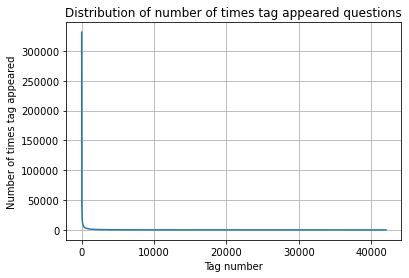

In [49]:
import matplotlib.pyplot as plt
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

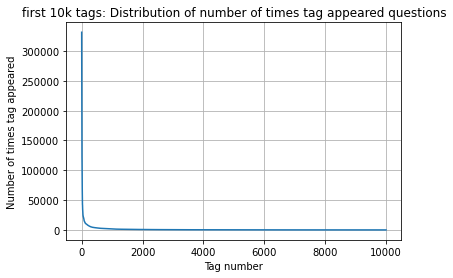

In [50]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

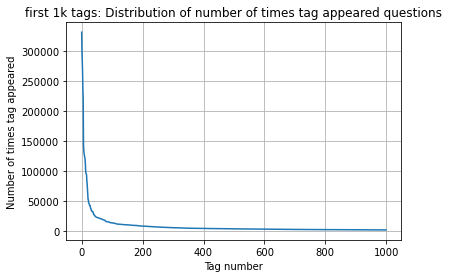

In [51]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

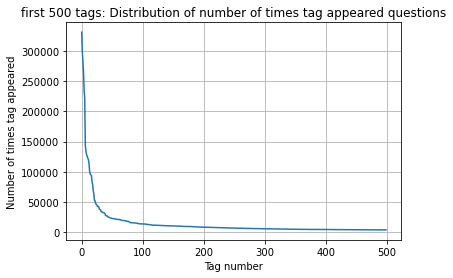

In [53]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()


In [54]:

list_10k = tags_df[tags_df.Counts>10000].Tags



print ('{} Tags are used more than 10000 times'.format(len(list_10k)))



list_100k = tags_df[tags_df.Counts>100000].Tags



print ('{} Tags are used more than 100000 times'.format(len(list_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


### Observations

1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

### Tags Per Question

In [59]:
#Storing the count of tag in each question in list 'tag_count'
row_sum = vector_tags.sum(axis=1).tolist()

#Converting each value in the 'row_sum' to integer.
tags_per_ques  =[int(j) for i in row_sum for j in i]


In [60]:
print( "Maximum number of tags per question: ", max(tags_per_ques))
print( "Minimum number of tags per question: ", min(tags_per_ques))
print( "Avg. number of tags per question:", ((sum(tags_per_ques)*1.0)/len(tags_per_ques)))

Maximum number of tags per question:  5
Minimum number of tags per question:  1
Avg. number of tags per question: 2.8994397470089015


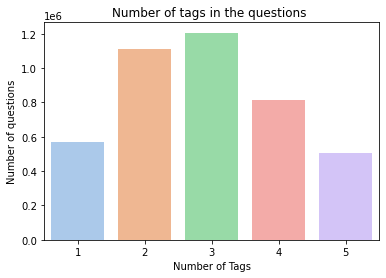

In [63]:
import seaborn as sns
sns.countplot(tags_per_ques, palette='pastel')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

### Observations

1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

### Most Frequent Tags

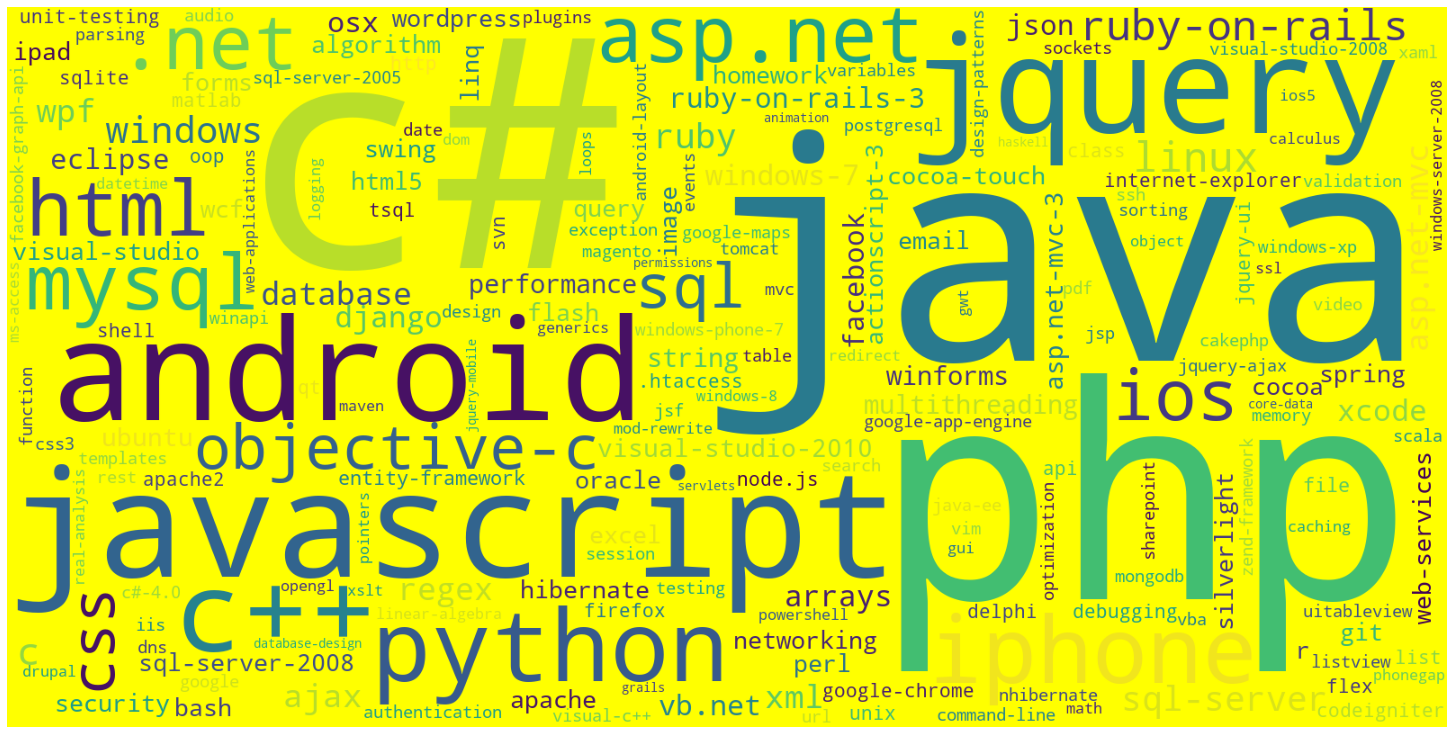

In [71]:
# Ploting word cloud
from datetime import datetime
from wordcloud import WordCloud 

# Converting the 'result' dictionary to 'list of tuples'
freq = dict(result.items())


#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(background_color='yellow',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(freq)

fig = plt.figure(figsize=(20,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

In [72]:
tag_df_sorted

,Tags,Counts
4337,c#,331505
18069,java,299414
27249,php,284103
18157,javascript,265423
1234,android,235436
...,...,...
29936,rbindlist,1
29934,rbga,1
29930,rbar,1
2925,azureus,1


In [87]:
tag_df_sorted = tag_df_sorted.reset_index()
del tag_df_sorted['index'] 
tag_df_sorted_30 = tag_df_sorted.iloc[0:30,:]

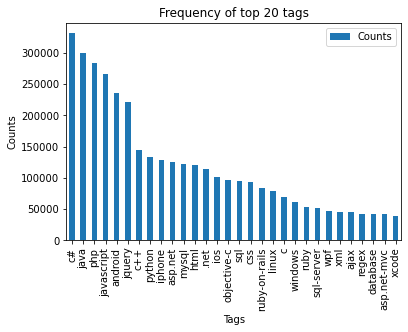

In [89]:
# Plotting the frquency of top 30 tags
i=np.arange(30)
tag_df_sorted_30.plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted_30['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

### Observations

1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

# Data Preprocessing

In [90]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re


# Defining a function to remove Html code
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext

# Initiziling the stop words and stemmer
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [93]:
sliced_data = filtered_data.iloc[:500001,:]

In [99]:
sliced_data

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents
...,...,...,...,...
515039,515040,Android Facebook API not sending APP Requests,<p>I am using the Android Hackbook app. I have...,android facebook
515040,515041,Add and remove class to make div appear and hide,<p>I am using jQuery to show and hide a div by...,jquery css forms show-hide
515041,515042,BCE0019: 'position' is not a member of 'Object'.,"<p>Thats Unity3D js script error, on pc it wor...",javascript unity3d
515042,515043,Python: Searching/reading binary data,<p>I'm reading in a binary file (a jpg in this...,python binary


In [117]:
from nltk.tokenize import word_tokenize
start = datetime.now()

question1 = []
code1 = []
tags1 = []
x1 = []
len_ques1 = []
is_code1 = []

preprocessed_data_list=[]
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for index,row in sliced_data.iterrows():
    
    is_code = 0
    
    title, question, tags = row['Title'], row['Body'], str(row['Tags'])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    #tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    question1.append(question)
    code1.append(code)
    tags1.append(tags)
    x1.append(x)
    len_ques1.append(len(question))
    is_code1.append(is_code)
    
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
Avg. length of questions(Title+Body) before processing: 1150
Avg. length of questions(Title+Body) after processing: 409
Percent of questions containing code: 56
Time taken to run this cell : 0:18:25.396969


In [120]:
preprocessed_data = pd.DataFrame([question1,code1,tags1,x1,len_ques1,is_code1])

In [121]:
preprocessed_data

,0,1,2,3,4,5,6,7,8,9,...,499991,499992,499993,499994,499995,499996,499997,499998,499999,500000
0,check upload file imag without mime type check...,prevent firefox close press ctrl-w prevent fir...,error invalid type list variabl error invalid ...,replac special charact url replac special char...,modifi whoi contact detail modifi whoi contact...,set proxi activ directori environ set proxi ac...,draw barplot way coreplot draw barplot way cor...,fetch xml feed use asp.net fetch xml feed use ...,.net librari generat javascript .net librari g...,sql server procedur call inlin concaten imposs...,...,c bind xml combobox via dataset c bind xml com...,problem ie remov new line content .text proble...,get one e-mail address page use xpath get one ...,dbcontext generat ef target old version .net c...,group anonym type vb.net linq object group ano...,android facebook api send app request android ...,add remov class make div appear hide add remov...,bce0019 posit member object bce0019 posit memb...,python search read binari data python search r...,magic mous caus mous prefer pane crash magic m...
1,[],[],"[""Error in model.frame.default(formula = exper...",[],['function modify(.......)\n{\n $mcontact = f...,[],[],['HttpWebRequest request = HttpWebRequest.Crea...,[],['EXEC dbo.myProcedure (SELECT columnName FROM...,...,['DataSet dataSet = new DataSet();\nDataTable ...,"['&lt;div id=""content""&gt;\n&lt;p&gt;hello wor...","[""//a/contains(@href,'@')"", '&lt;a href=""mailt...",[],['void Main()\n{\n var items = GetArray(\n ...,['Bundle params = new Bundle();\n params.pu...,['$(\'input\').focus(function(){\n $(this)....,[' var RelativeWaypointPosition : Vector3 =...,[],[]
2,php image-processing file-upload upload mime-t...,firefox,r matlab machine-learning,c# url encoding,php api file-get-contents,proxy active-directory jmeter,core-plot,c# asp.net windows-phone-7,.net javascript code-generation,sql variables parameters procedure calls,...,c# xml dataset,javascript jquery internet-explorer internet-e...,xml xpath,visual-studio entity-framework dbcontext,vb.net linq c#-to-vb.net,android facebook,jquery css forms show-hide,javascript unity3d,python binary,osx-snow-leopard magic-mouse system-preferences
3,471,418,13572,607,1026,430,622,912,602,480,...,896,714,666,1392,916,881,1003,504,689,361
4,357,315,332,332,155,302,256,469,404,262,...,308,265,384,866,289,411,453,157,346,271
5,0,0,1,0,1,0,0,1,0,1,...,1,1,1,0,1,1,1,1,0,0


In [122]:
preprocessed_data = list(zip(question1,code1,tags1,x1,len_ques1,is_code1))
preprocessed_data = pd.DataFrame(preprocessed_data, columns = ['question','code','tags','x','len_ques','is_code'])

In [125]:
preprocessed_data = preprocessed_data[['question','tags']]

In [127]:
preprocessed_data.head()

,question,tags
0,check upload file imag without mime type check...,php image-processing file-upload upload mime-t...
1,prevent firefox close press ctrl-w prevent fir...,firefox
2,error invalid type list variabl error invalid ...,r matlab machine-learning
3,replac special charact url replac special char...,c# url encoding
4,modifi whoi contact detail modifi whoi contact...,php api file-get-contents


In [128]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 500001
number of dimensions : 2


Converting string Tags to multilable output variables

In [129]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
labels = vectorizer.fit_transform(preprocessed_data['tags'])

### Selecting 500 tags

In [134]:
def tags_to_choose(x):
    l = labels.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(l)), key=lambda i: l[i], reverse=True)
    labels_n= labels[:,sorted_tags_i[:x]]
    return labels_n

def questions_explained_function(x):
    labels_n = tags_to_choose(x)
    m = labels_n.sum(axis=1)
    return (np.count_nonzero(m==0))

In [135]:
questions_explained = []
total_number_tags = labels.shape[1]
total_number_questions = preprocessed_data.shape[0]
for i in range(500, total_number_tags, 100):
    questions_explained.append(np.round(((total_number_questions - questions_explained_function(i))/total_number_questions)*100,3))

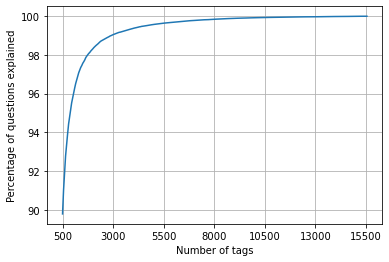

with  5500 tags we are covering  99.049 % of questions


In [137]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Percentage of questions explained")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [139]:
choose = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_function(5500),"out of ", total_number_questions)

number of questions that are not covered : 4756 out of  500001


In [140]:
print("Number of tags in sample :", labels.shape[1])
print("number of tags taken :", choose.shape[1],"(",(choose.shape[1]/labels.shape[1])*100,"%)")

Number of tags in sample : 30645
number of tags taken : 5500 ( 17.947462881383586 %)
